In [1]:
# Importing Libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'r-jyxJDkUevy-JyGxppU'

In [3]:
# Importing the Zillow Real Estate Data
data = quandl.get_table('ZILLOW/DATA')

In [4]:
data.head(5)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2023-05-31,475773.959428
1,ZSFH,99999,2023-04-30,475808.561280
2,ZSFH,99999,2023-03-31,478245.160686
3,ZSFH,99999,2023-02-28,447694.734130
4,ZSFH,99999,2023-01-31,442532.972885


In [5]:
data.shape

(10000, 4)

In [6]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [7]:
data['indicator_id'].unique()

array(['ZSFH'], dtype=object)

In [8]:
data['region_id'].unique()

array(['99999', '99998', '99997', '99996', '99995', '99994', '99993',
       '99992', '99991', '99990', '9999', '99989', '99988', '99987',
       '99986', '99985', '99984', '99983', '99982', '99980', '9998',
       '99979', '99978', '99977', '99976', '99975', '99974', '99973',
       '99972', '99971', '99970', '99968', '99967', '99965', '99964',
       '99963', '99962', '99961', '99960', '99959', '99958'], dtype=object)

In [9]:
data2 = data.groupby('date')['value'].sum()

In [10]:
data2.shape

(329,)

In [11]:
data2.head(5)

date
1996-01-31    1135696.0
1996-02-29    1140810.0
1996-03-31    1143220.0
1996-04-30    1149464.0
1996-05-31    1158118.0
Name: value, dtype: float64

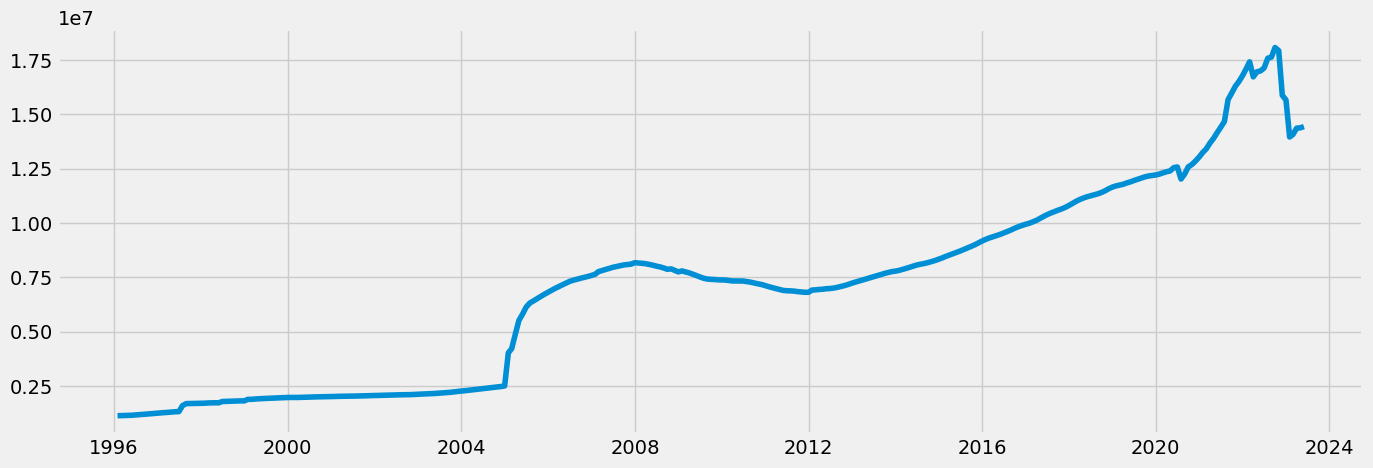

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data2)

In [13]:
data2.isnull().sum()

0

In [14]:
dups = data2.duplicated()
dups.sum()

0

## Time-series analysis: decomposition

In [15]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data2, model='additive')

In [16]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

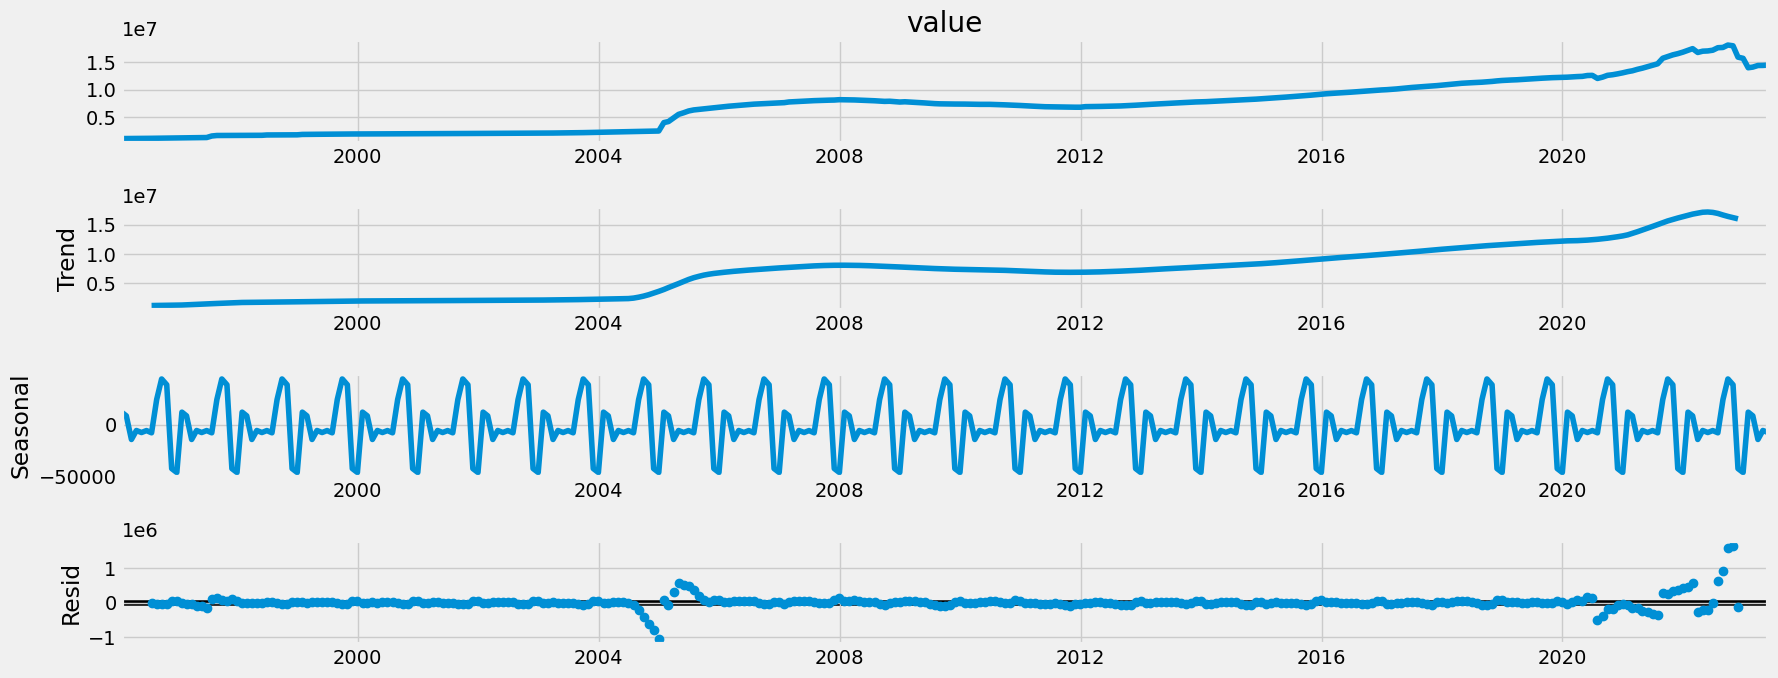

In [17]:
# Plot the separate components

decomposition.plot()
plt.show()

## Testing for stationarity

#### Null hypothesis: There is a unit root.

In [18]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data2)

Dickey-Fuller Stationarity test:
Test Statistic                  -0.389145
p-value                          0.911895
Number of Lags Used             15.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64


Test Statistic value is greater than Critical value, hence we can't reject the null hypothesis

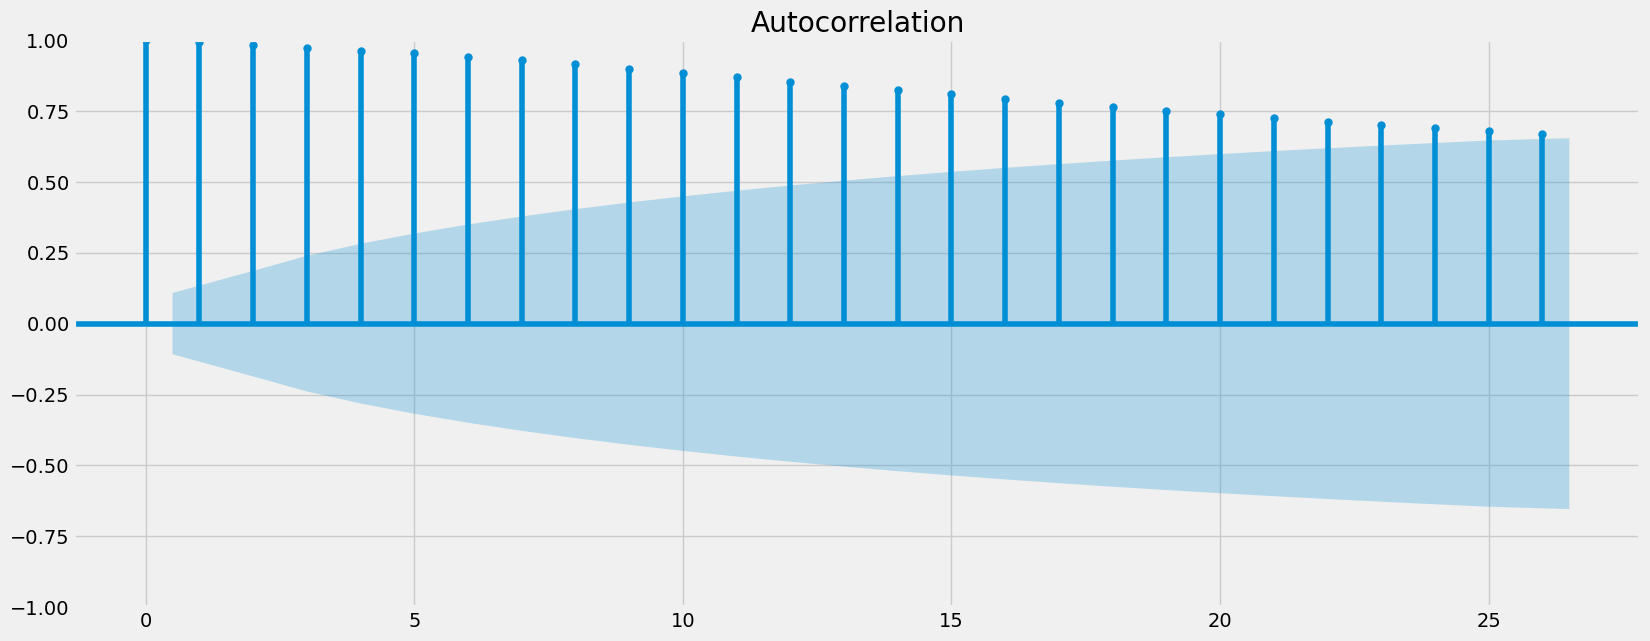

In [19]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data2)
plt.show()

## Stationarizing the Data

In [20]:
data_diff = data2 - data2.shift(1) # The df.shift(2) function turns the observation to t-1, making the whole thing t - (t -1)

In [21]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [22]:
data_diff.head()

date
1996-02-29     5114.0
1996-03-31     2410.0
1996-04-30     6244.0
1996-05-31     8654.0
1996-06-30    12163.0
Name: value, dtype: float64

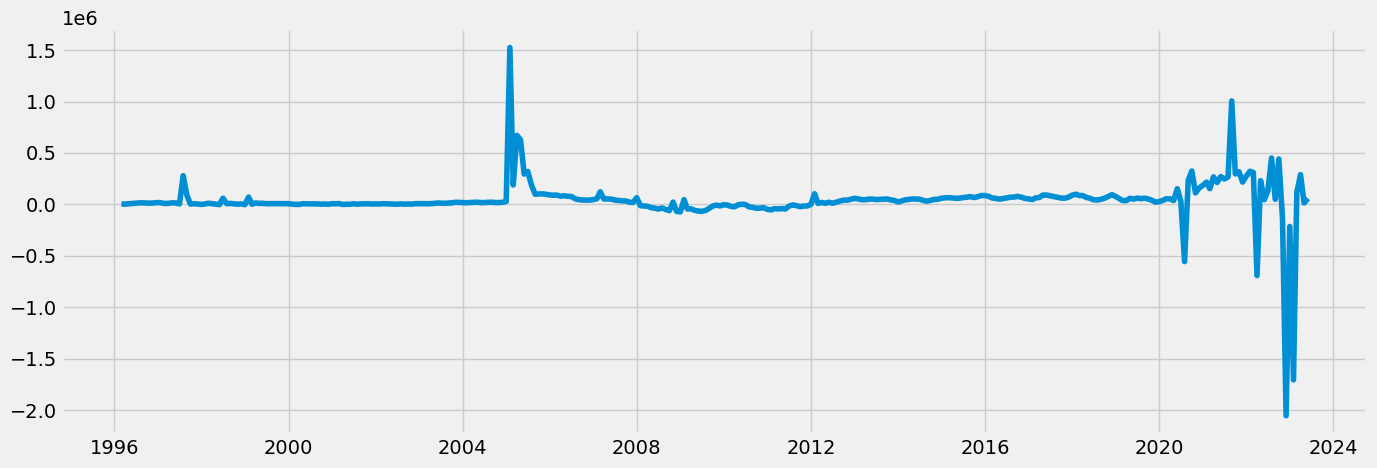

In [23]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [24]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.436655
p-value                          0.000255
Number of Lags Used             14.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64


Critical value is greater than Test Statistic, hence we can reject the null hypothesis

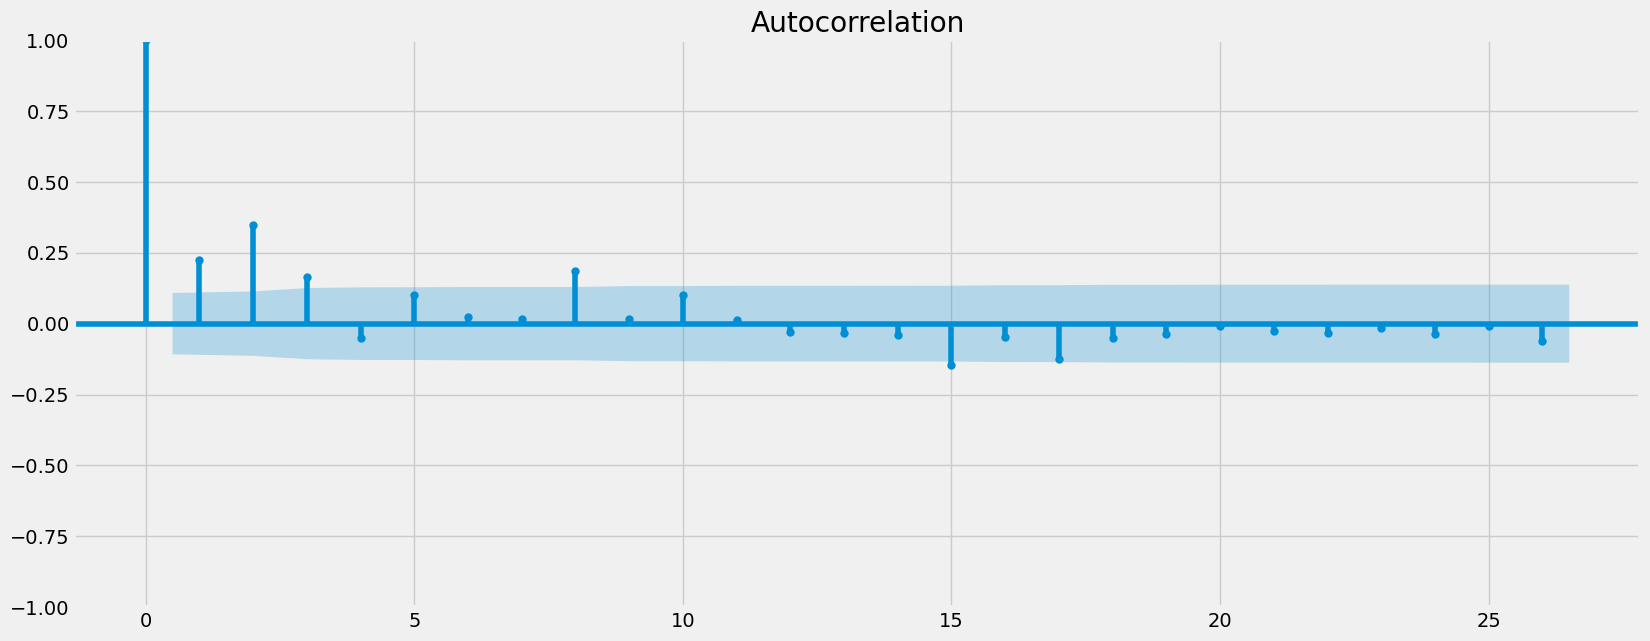

In [25]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot has much fewer autocorrelated terms and another round of differencing to stationarize the data is not necessary.